In [1]:
import pandas as pd
import numpy as np
from IPython.display import Math #para escrever equações 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import seaborn as sns

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [3]:
RANDOM_SIZE   = 1000000
RANDOM_SIZE   = 1003
# QTD_BINS      = 3
TEST_SIZE     = 0.05
RANDOM_STATE  = 2022

- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_commodity_types.csv
- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_vegetable_oil.csv
- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_full.csv

# Mercado de Oleo

## Dataset Completo
USDA por comodity
USDA Agrupado por Oleo Vegetal
OECD Agrupado
FAO Index Price


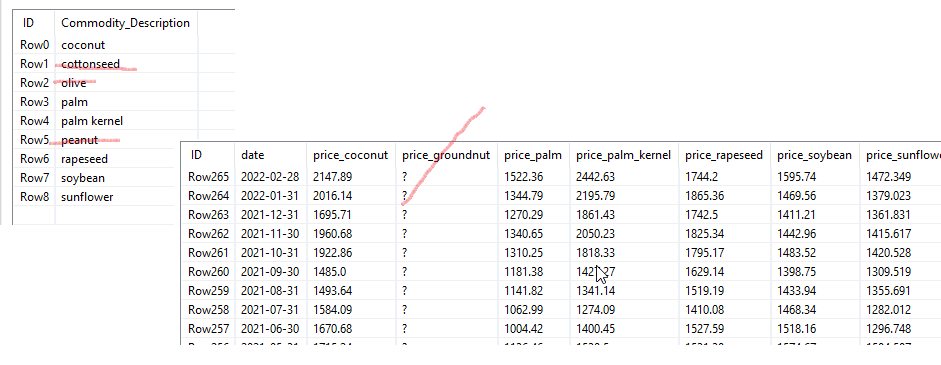

In [4]:

def get_dataset():
  df = pd.read_csv('https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_full.csv')
  print(df.shape)
  df['date'] = pd.to_datetime(df['date'])
  df.sort_values(by=['date'], ascending=[True], inplace=True)
  df.set_index(['date'], inplace=True)
  return df

%time df_full = get_dataset()
df_full.head()

(266, 139)
CPU times: total: 78.1 ms
Wall time: 385 ms


,reference,price_index_fao,coconut_beginning_stocks,coconut_crush,coconut_domestic_consumption,coconut_ending_stocks,coconut_exports,coconut_feed_waste_dom_cons,coconut_food_use_dom_cons,coconut_imports,...,palm_kernel_domestic_consumption,palm_kernel_ending_stocks,palm_kernel_exports,palm_kernel_feed_waste_dom_cons,palm_kernel_food_use_dom_cons,palm_kernel_imports,palm_kernel_industrial_dom_cons,palm_kernel_production,palm_kernel_total_distribution,palm_kernel_total_supply
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,48.583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,46.368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,NaN,47.819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,NaN,49.499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,NaN,44.489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2000-01-31 to 2022-02-28
Columns: 138 entries, reference to palm_kernel_total_supply
dtypes: float64(137), object(1)
memory usage: 288.9+ KB


In [6]:
df_full.dtypes

reference                           object
price_index_fao                    float64
coconut_beginning_stocks           float64
coconut_crush                      float64
coconut_domestic_consumption       float64
                                    ...   
palm_kernel_imports                float64
palm_kernel_industrial_dom_cons    float64
palm_kernel_production             float64
palm_kernel_total_distribution     float64
palm_kernel_total_supply           float64
Length: 138, dtype: object

In [7]:
features = [x for x in df_full.columns if ('exports' in x or 'production' in x or 'price' in x) and not ('olive' in x or 'cottonseed' in x) ]
prices = [x for x in df_full.columns if 'price' in x and 'groundnut' not in x  ]
print(len(features), features)
print(len(prices), prices)

26 ['price_index_fao', 'coconut_exports', 'coconut_price', 'coconut_production', 'palm kernel_price', 'palm_exports', 'palm_price', 'palm_production', 'peanut_exports', 'peanut_price', 'peanut_production', 'rapeseed_exports', 'rapeseed_price', 'rapeseed_production', 'soybean_exports', 'soybean_price', 'soybean_production', 'sunflower_exports', 'sunflower_price', 'sunflower_production', 'vegetable_oil_exports_usda', 'vegetable_oil_production_usda', 'vegetable_oils_exports_oecd', 'vegetable_oils_production_oecd', 'palm_kernel_exports', 'palm_kernel_production']
8 ['price_index_fao', 'coconut_price', 'palm kernel_price', 'palm_price', 'peanut_price', 'rapeseed_price', 'soybean_price', 'sunflower_price']


In [8]:
df = df_full[features]
print(df.shape)
df = df[df['sunflower_production'].notnull()]
df = df[df['sunflower_price'].notnull()]
print(df.shape)
df

(266, 26)
(234, 26)


,price_index_fao,coconut_exports,coconut_price,coconut_production,palm kernel_price,palm_exports,palm_price,palm_production,peanut_exports,peanut_price,...,soybean_production,sunflower_exports,sunflower_price,sunflower_production,vegetable_oil_exports_usda,vegetable_oil_production_usda,vegetable_oils_exports_oecd,vegetable_oils_production_oecd,palm_kernel_exports,palm_kernel_production
date,,,,,,,,,,,,,,,,,,,,,
2002-02-28,47.786,148.440,376.000,255.940,356.000,1527.920,352.980,2146.310,17.030,617.290,...,3204.320,166.180,578.000,620.920,3312.180,8559.630,2986.310,7954.130,130.470,264.710
2002-03-31,47.622,148.040,366.000,255.830,353.240,1543.880,359.000,2162.830,16.580,598.920,...,3222.400,168.850,557.000,625.580,3339.800,8591.720,3014.280,7983.170,130.830,266.520
2002-04-30,48.969,147.640,411.000,255.720,405.000,1559.830,360.070,2179.360,16.140,590.240,...,3240.470,171.530,552.000,630.250,3367.440,8623.810,3042.260,8012.210,131.190,268.330
2002-05-31,51.641,147.240,420.000,255.610,418.300,1575.790,384.910,2195.890,15.690,599.560,...,3258.550,174.200,574.000,634.920,3395.080,8655.950,3070.240,8041.250,131.560,270.150
2002-06-30,55.804,146.830,446.000,255.500,439.000,1591.750,426.130,2212.420,15.250,645.950,...,3276.620,176.880,595.000,639.580,3422.710,8688.040,3098.220,8070.290,131.920,271.960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,165.862,157.080,1493.640,290.610,1341.140,4092.220,1141.820,6229.440,35.640,NaN,...,6354.170,988.220,1355.691,1703.690,7821.270,18894.320,7325.470,18174.560,276.780,716.470
2021-09-30,168.571,158.080,1485.000,291.080,1427.270,4103.190,1181.380,6246.960,35.020,NaN,...,6350.750,994.670,1309.519,1717.600,7837.790,18923.870,7328.510,18207.820,278.380,718.600
2021-10-31,184.837,159.080,1922.860,291.560,1818.330,4114.150,1310.250,6264.470,34.400,NaN,...,6347.330,1001.110,1420.528,1731.510,7854.300,18953.420,7331.560,18241.070,279.970,720.740


In [9]:
df.describe()

,price_index_fao,coconut_exports,coconut_price,coconut_production,palm kernel_price,palm_exports,palm_price,palm_production,peanut_exports,peanut_price,...,soybean_production,sunflower_exports,sunflower_price,sunflower_production,vegetable_oil_exports_usda,vegetable_oil_production_usda,vegetable_oils_exports_oecd,vegetable_oils_production_oecd,palm_kernel_exports,palm_kernel_production
count,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,221.000,...,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000
mean,103.046,154.793,1037.208,277.760,956.092,3226.635,763.075,4406.418,19.901,1483.936,...,4857.446,563.021,966.043,1174.819,5990.575,14277.728,5545.769,13471.372,233.840,523.365
std,32.741,10.334,412.612,12.313,378.930,805.918,244.906,1262.844,6.470,383.791,...,980.073,284.888,334.951,331.668,1329.965,3166.837,1307.176,3118.232,41.691,139.269
min,47.622,123.000,366.000,248.500,353.240,1527.920,352.980,2146.310,12.830,590.240,...,3204.320,166.180,543.000,620.920,3312.180,8559.630,2986.310,7954.130,130.470,264.710
25%,78.436,148.055,702.250,270.998,655.290,2515.020,577.495,3275.315,15.468,1287.500,...,4057.825,329.412,719.643,886.732,5027.562,11538.903,4463.065,10815.903,219.213,399.255
50%,97.910,154.895,953.500,275.410,878.330,3399.860,732.000,4468.605,16.805,1404.950,...,4667.785,493.780,856.470,1127.385,5927.510,14325.960,5663.720,13418.630,245.990,530.115
75%,121.403,160.400,1387.287,287.767,1232.705,4014.682,886.188,5503.118,23.133,1633.340,...,5831.602,867.900,1174.505,1528.378,7278.573,17158.577,6772.868,16394.708,263.450,642.967
max,184.837,177.920,2256.000,302.500,2307.630,4325.500,1377.220,6299.500,40.580,2502.250,...,6381.500,1122.670,2045.000,1761.580,7887.340,19012.500,7349.260,18307.580,283.170,725.000


## Correlação


In [10]:
if False:
  %time
  sns.set_theme(style="white")

  g = sns.PairGrid(df, diag_sharey=False)
  g.map_upper(sns.scatterplot, s=15)
  g.map_lower(sns.kdeplot)
  g.map_diag(sns.kdeplot, lw=2)

![Alt text](https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/images/Compare.png)

## Dendograma

In [11]:
if False:
  %time
  plt.figure(figsize=(25,10))
  dendrogram = sch.dendrogram(sch.linkage(df, method  = "ward"))

  plt.title('Dendrogram')

  # plt.xlabel('Customers')
  plt.ylabel('Euclidean distances')
  plt.show()

# Markov

In [12]:
!pip install --upgrade quantecon numba tqdm

     -------------------------------------- 179.5/179.5 KB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 78.4/78.4 KB ? eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.63.1
    Uninstalling tqdm-4.63.1:
      Successfully uninstalled tqdm-4.63.1
  Attempting uninstall: quantecon
    Found existing installation: quantecon 0.5.2
    Uninstalling quantecon-0.5.2:
      Successfully uninstalled quantecon-0.5.2


In [13]:
from random import randint
from xmlrpc.client import Boolean
from tqdm import tqdm
import pandas as pd
import numpy as np
import quantecon as qe

import logging
log = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG) 

In [14]:
df.tail()

,price_index_fao,coconut_exports,coconut_price,coconut_production,palm kernel_price,palm_exports,palm_price,palm_production,peanut_exports,peanut_price,...,soybean_production,sunflower_exports,sunflower_price,sunflower_production,vegetable_oil_exports_usda,vegetable_oil_production_usda,vegetable_oils_exports_oecd,vegetable_oils_production_oecd,palm_kernel_exports,palm_kernel_production
date,,,,,,,,,,,,,,,,,,,,,
2021-08-31,165.862,157.080,1493.640,290.610,1341.140,4092.220,1141.820,6229.440,35.640,NaN,...,6354.170,988.220,1355.691,1703.690,7821.270,18894.320,7325.470,18174.560,276.780,716.470
2021-09-30,168.571,158.080,1485.000,291.080,1427.270,4103.190,1181.380,6246.960,35.020,NaN,...,6350.750,994.670,1309.519,1717.600,7837.790,18923.870,7328.510,18207.820,278.380,718.600
2021-10-31,184.837,159.080,1922.860,291.560,1818.330,4114.150,1310.250,6264.470,34.400,NaN,...,6347.330,1001.110,1420.528,1731.510,7854.300,18953.420,7331.560,18241.070,279.970,720.740
2021-11-30,184.555,160.080,1960.680,292.030,2050.230,4125.120,1340.650,6281.990,33.780,NaN,...,6343.920,1007.560,1415.617,1745.420,7870.820,18982.970,7334.600,18274.330,281.570,722.870
2021-12-31,178.505,161.080,1695.710,292.500,1861.430,4136.080,1270.290,6299.500,33.170,NaN,...,6340.500,1014.000,1361.831,1759.330,7887.340,19012.500,7337.650,18307.580,283.170,725.000


## Geração do Random Sets

In [15]:
def prepare_dataset(df: pd.DataFrame):
  df = df.copy()
  for col in df.columns:
    df[f'{col}_delta']    = df[col].diff()
    df[f'{col}_outcome']  = df[col].diff(-1) * -1
    df[f'{col}_mom']      = df[col].pct_change()

  columns = sorted(list(df.columns))
  return df[columns].reset_index()


df_m = prepare_dataset(df)
df_m.tail(10).T

,224,225,226,227,228,229,230,231,232,233
date,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00,2021-10-31 00:00:00,2021-11-30 00:00:00,2021-12-31 00:00:00
coconut_exports,152.080,153.080,154.080,155.080,156.080,157.080,158.080,159.080,160.080,161.080
coconut_exports_delta,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
coconut_exports_mom,0.007,0.007,0.007,0.006,0.006,0.006,0.006,0.006,0.006,0.006
coconut_exports_outcome,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,NaN
...,...,...,...,...,...,...,...,...,...,...
vegetable_oils_exports_oecd_outcome,3.050,3.040,3.050,3.040,3.050,3.040,3.050,3.040,3.050,NaN
vegetable_oils_production_oecd,18008.290,18041.550,18074.800,18108.060,18141.310,18174.560,18207.820,18241.070,18274.330,18307.580
vegetable_oils_production_oecd_delta,33.250,33.260,33.250,33.260,33.250,33.250,33.260,33.250,33.260,33.250
vegetable_oils_production_oecd_mom,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002


In [16]:
df_m.tail()

,date,coconut_exports,coconut_exports_delta,coconut_exports_mom,coconut_exports_outcome,coconut_price,coconut_price_delta,coconut_price_mom,coconut_price_outcome,coconut_production,...,vegetable_oil_production_usda_mom,vegetable_oil_production_usda_outcome,vegetable_oils_exports_oecd,vegetable_oils_exports_oecd_delta,vegetable_oils_exports_oecd_mom,vegetable_oils_exports_oecd_outcome,vegetable_oils_production_oecd,vegetable_oils_production_oecd_delta,vegetable_oils_production_oecd_mom,vegetable_oils_production_oecd_outcome
229,2021-08-31,157.080,1.000,0.006,1.000,1493.640,-90.450,-0.057,-8.640,290.610,...,0.002,29.550,7325.470,3.050,0.000,3.040,18174.560,33.250,0.002,33.260
230,2021-09-30,158.080,1.000,0.006,1.000,1485.000,-8.640,-0.006,437.860,291.080,...,0.002,29.550,7328.510,3.040,0.000,3.050,18207.820,33.260,0.002,33.250
231,2021-10-31,159.080,1.000,0.006,1.000,1922.860,437.860,0.295,37.820,291.560,...,0.002,29.550,7331.560,3.050,0.000,3.040,18241.070,33.250,0.002,33.260
232,2021-11-30,160.080,1.000,0.006,1.000,1960.680,37.820,0.020,-264.970,292.030,...,0.002,29.530,7334.600,3.040,0.000,3.050,18274.330,33.260,0.002,33.250
233,2021-12-31,161.080,1.000,0.006,NaN,1695.710,-264.970,-0.135,NaN,292.500,...,0.002,NaN,7337.650,3.050,0.000,NaN,18307.580,33.250,0.002,NaN


In [17]:
def get_random_sets(input_dataframe: pd.DataFrame, 
                    size = 100000,
                    **kwargs):
    
    # take random sets of sequential rows 
    new_set = []

    # breakpoint()
    
    log.debug(f'AQUI:   {size}')
    for row_set in (tqdm(iterable = range(0, size), bar_format='{desc:<15}{percentage:3.0f}%|{bar:50}{r_bar}' ) ):
        
        # obtem de forma randomica uma amostra de n linhas do dataset
        # entre 3 e 18 meses
        row_quant     = randint(3, 18)
        row_start     = randint(0, len(input_dataframe) - row_quant)
        row_finish    = row_start + row_quant
        
        market_subset = input_dataframe.iloc[row_start:row_finish]

        # log.debug(f'AQUI:   {row_start} |{row_finish} | {market_subset.shape}')
        
        Close_Date    = max(market_subset['date'])
        

        if row_set%(size//5)==0:
            pass
            print(f'row_set: {row_set:<6} | row_quant: {row_quant:2} | rows: {row_start:>6}-{row_finish-1:<6} | market_subset: {str(market_subset.shape):^10} | Close_Date: {Close_Date:%m/%d/%Y}')
        
        ref = {}
        ref['Sequence_ID']  = [row_set]*len(market_subset)          # poderia ser 'row_quant' ao inves de 'len(market_subset)'
        ref['Close_Date']   = [Close_Date]*len(market_subset)
        ref['ref_date']   = market_subset['date']
        
        columns_ref = {}
        
        if 'columns' in kwargs and isinstance(kwargs['columns'], list):
            for _col in kwargs['columns']:
                if _col in input_dataframe.columns:
                    columns_ref[_col] = market_subset[_col]
                    columns_ref[f'{_col}_variation'] = market_subset[_col].pct_change()
                    
                    if 'outcomes' in kwargs and isinstance(kwargs['outcomes'], list) and _col in kwargs['outcomes']:
                        columns_ref[f'{_col}_outcome'] = market_subset[_col].diff(-1) * -1
            
        
        if 'bypass' in kwargs and isinstance(kwargs['bypass'], list):
            for _col in kwargs['bypass']:
                columns_ref[_col] = market_subset[_col]
               
        # columns_ref = dict( sorted(columns_ref.items(), key=lambda x: x[0].lower()) )
        
        #merge dictionaries
        ref = {**ref, **columns_ref}
        
        new_set.append(pd.DataFrame(ref))
        
    return new_set

# get_random_sets(df_m, RANDOM_SIZE)

In [18]:
%time my_set = get_random_sets(df.reset_index(), RANDOM_SIZE,columns=features,  outcomes=features, bypass=[])

DEBUG:__main__:AQUI:   1003
                 1%|▋                                                 | 13/1003 [00:00<00:18, 54.79it/s]

row_set: 0      | row_quant:  5 | rows:    202-206    | market_subset:  (5, 27)   | Close_Date: 09/30/2019


                21%|██████████▌                                       | 212/1003 [00:04<00:15, 49.67it/s]

row_set: 200    | row_quant: 17 | rows:    131-147    | market_subset:  (17, 27)  | Close_Date: 10/31/2014


                41%|████████████████████▎                             | 407/1003 [00:08<00:11, 53.70it/s]

row_set: 400    | row_quant: 10 | rows:    107-116    | market_subset:  (10, 27)  | Close_Date: 03/31/2012


                61%|██████████████████████████████▍                   | 610/1003 [00:12<00:07, 54.65it/s]

row_set: 600    | row_quant:  3 | rows:     69-71     | market_subset:  (3, 27)   | Close_Date: 06/30/2008


                81%|████████████████████████████████████████▎         | 809/1003 [00:16<00:04, 48.00it/s]

row_set: 800    | row_quant:  8 | rows:     52-59     | market_subset:  (8, 27)   | Close_Date: 06/30/2007


               100%|██████████████████████████████████████████████████| 1003/1003 [00:20<00:00, 48.53it/s]

row_set: 1000   | row_quant:  7 | rows:    182-188    | market_subset:  (7, 27)   | Close_Date: 03/31/2018
CPU times: total: 20.6 s
Wall time: 20.7 s


In [19]:
def convet_collection_to_dataframe(collection):
    """
    Concatena todas as colecoes
    Remove os np.inf e np.nan, gerados pelo pc_c
    """
    df_out = pd.concat(collection)
    
    log.debug(f'Before dropping NaNs: {df_out.shape}')
    df_out.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_out = df_out.dropna(how='any') 
    log.debug(f'After dropping NaNs: {df_out.shape}')
    return df_out

In [20]:
%time df1 = convet_collection_to_dataframe(my_set)
df1

DEBUG:__main__:Before dropping NaNs: (10460, 81)
DEBUG:__main__:After dropping NaNs: (8177, 81)


CPU times: total: 109 ms
Wall time: 109 ms


,Sequence_ID,Close_Date,ref_date,price_index_fao,price_index_fao_variation,price_index_fao_outcome,coconut_exports,coconut_exports_variation,coconut_exports_outcome,coconut_price,...,vegetable_oils_exports_oecd_outcome,vegetable_oils_production_oecd,vegetable_oils_production_oecd_variation,vegetable_oils_production_oecd_outcome,palm_kernel_exports,palm_kernel_exports_variation,palm_kernel_exports_outcome,palm_kernel_production,palm_kernel_production_variation,palm_kernel_production_outcome
203,0,2019-09-30,2019-06-30,77.462,-0.013,0.628,166.960,-0.011,-1.830,635.600,...,-15.650,17656.830,0.000,4.060,278.380,-0.002,-0.690,713.170,-0.001,-0.430
204,0,2019-09-30,2019-07-31,78.090,0.008,4.499,165.130,-0.011,-1.820,657.310,...,-15.660,17660.890,0.000,4.060,277.690,-0.002,-0.690,712.740,-0.001,-0.430
205,0,2019-09-30,2019-08-31,82.589,0.058,1.299,163.310,-0.011,-1.830,719.280,...,-15.660,17664.950,0.000,4.060,277.000,-0.002,-0.690,712.310,-0.001,-0.430
8,1,2003-06-30,2003-03-31,59.234,-0.050,0.333,145.500,0.002,0.360,441.000,...,16.010,8371.450,0.005,42.310,137.580,0.009,1.170,289.350,0.008,2.180
9,1,2003-06-30,2003-04-30,59.567,0.006,1.525,145.860,0.002,0.360,421.000,...,16.010,8413.760,0.005,42.310,138.750,0.009,1.170,291.530,0.008,2.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,1002,2015-03-31,2014-10-31,100.091,0.016,0.760,161.380,0.001,0.180,1148.700,...,36.560,15049.770,0.004,62.320,264.890,0.010,2.510,606.820,0.003,1.710
148,1002,2015-03-31,2014-11-30,100.851,0.008,-2.959,161.560,0.001,0.190,1191.630,...,36.570,15112.090,0.004,62.330,267.400,0.009,2.520,608.530,0.003,1.720
149,1002,2015-03-31,2014-12-31,97.892,-0.029,-2.892,161.750,0.001,-2.520,1212.140,...,-24.600,15174.420,0.004,-17.330,269.920,0.009,-1.510,610.250,0.003,-2.120
150,1002,2015-03-31,2015-01-31,95.000,-0.030,0.180,159.230,-0.016,-2.520,1145.710,...,-24.600,15157.090,-0.001,-17.330,268.410,-0.006,-1.510,608.130,-0.003,-2.120


In [21]:
outcomes = [x for x in df1.columns if 'outcome' in x  ]
outcomes

['price_index_fao_outcome',
 'coconut_exports_outcome',
 'coconut_price_outcome',
 'coconut_production_outcome',
 'palm kernel_price_outcome',
 'palm_exports_outcome',
 'palm_price_outcome',
 'palm_production_outcome',
 'peanut_exports_outcome',
 'peanut_price_outcome',
 'peanut_production_outcome',
 'rapeseed_exports_outcome',
 'rapeseed_price_outcome',
 'rapeseed_production_outcome',
 'soybean_exports_outcome',
 'soybean_price_outcome',
 'soybean_production_outcome',
 'sunflower_exports_outcome',
 'sunflower_price_outcome',
 'sunflower_production_outcome',
 'vegetable_oil_exports_usda_outcome',
 'vegetable_oil_production_usda_outcome',
 'vegetable_oils_exports_oecd_outcome',
 'vegetable_oils_production_oecd_outcome',
 'palm_kernel_exports_outcome',
 'palm_kernel_production_outcome']

## Divisao do dataset em Quantis

In [22]:
get_divison = lambda size: [item / size for item in list(range(size + 1))]
get_labels = lambda size: [f'{chr( (item % 26) + 65 )}{ "" if item // 26 <= 0 else item // 26 }' for item in list(range(size))]
get_full = lambda size: [ (chr(i + 65), f'{j / size} < x <= { (j+1) / size}' ) for i , j in enumerate(range(size))]
get_bins = lambda _input_array, size:  np.round(np.linspace(_input_array.min(), _input_array.max(), size + 1), 6).tolist()


def read_kwarg_list(kwargs, name, _else_conditions = None):
    if name in kwargs and isinstance(kwargs[name], list):
        return kwargs[name]
    return _else_conditions

def read_kwarg_bool(kwargs, name):
    if name in kwargs and isinstance(kwargs[name], Boolean):
        return kwargs[name]
    return False
        

In [23]:
def quantiles(df: pd.DataFrame, labels: list):
  df    = df.copy()
  ref   = ''.join(labels).lower()
  size  = len(labels)

  columns_labels = []
  for col in df.columns:
    if 'variation' in col:
      column_name         = f'{col}_qcut'
      df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
      columns_labels.append(column_name)

  equation = ' + '.join( [f'df["{col}"].astype(str)' for col in columns_labels] )
  df['event_pattern']  = eval(equation) 
  columns_labels.append('event_pattern')

  return df
  return df[['Sequence_ID','Close_Date'] + columns_labels]
    

In [24]:
df2 = quantiles(df1, ['L','M','H'])
print(df2.shape)
df2.tail()

(8177, 108)


,Sequence_ID,Close_Date,ref_date,price_index_fao,price_index_fao_variation,price_index_fao_outcome,coconut_exports,coconut_exports_variation,coconut_exports_outcome,coconut_price,...,sunflower_exports_variation_qcut,sunflower_price_variation_qcut,sunflower_production_variation_qcut,vegetable_oil_exports_usda_variation_qcut,vegetable_oil_production_usda_variation_qcut,vegetable_oils_exports_oecd_variation_qcut,vegetable_oils_production_oecd_variation_qcut,palm_kernel_exports_variation_qcut,palm_kernel_production_variation_qcut,event_pattern
147,1002,2015-03-31,2014-10-31,100.091,0.016,0.760,161.380,0.001,0.180,1148.700,...,L,H,L,H,M,H,M,H,L,MMLMMHMLHLLMHMHMHLHLHMHMHL
148,1002,2015-03-31,2014-11-30,100.851,0.008,-2.959,161.560,0.001,0.190,1191.630,...,L,H,L,H,M,M,M,H,L,MMMMMHMLHLLMLMHMHLHLHMMMHL
149,1002,2015-03-31,2014-12-31,97.892,-0.029,-2.892,161.750,0.001,-2.520,1212.140,...,L,L,L,H,M,M,M,H,L,LMMMMHLLHLLMLLHMHLLLHMMMHL
150,1002,2015-03-31,2015-01-31,95.000,-0.030,0.180,159.230,-0.016,-2.520,1145.710,...,M,L,M,L,L,L,L,L,L,LLLLMLMLLLMLLLMLMMLMLLLLLL
151,1002,2015-03-31,2015-02-28,95.180,0.002,-2.565,156.710,-0.016,-2.520,1160.500,...,M,L,M,L,L,L,L,L,L,MLMMHLMLLLMLLLLLMMLMLLLLLL


In [25]:
outcomes

['price_index_fao_outcome',
 'coconut_exports_outcome',
 'coconut_price_outcome',
 'coconut_production_outcome',
 'palm kernel_price_outcome',
 'palm_exports_outcome',
 'palm_price_outcome',
 'palm_production_outcome',
 'peanut_exports_outcome',
 'peanut_price_outcome',
 'peanut_production_outcome',
 'rapeseed_exports_outcome',
 'rapeseed_price_outcome',
 'rapeseed_production_outcome',
 'soybean_exports_outcome',
 'soybean_price_outcome',
 'soybean_production_outcome',
 'sunflower_exports_outcome',
 'sunflower_price_outcome',
 'sunflower_production_outcome',
 'vegetable_oil_exports_usda_outcome',
 'vegetable_oil_production_usda_outcome',
 'vegetable_oils_exports_oecd_outcome',
 'vegetable_oils_production_oecd_outcome',
 'palm_kernel_exports_outcome',
 'palm_kernel_production_outcome']

## Compressing

In [26]:
def compress(input_dataframe: pd.DataFrame, **kwargs):
    columns         = read_kwarg_list(kwargs,'columns')
    outcomes        = read_kwarg_list(kwargs,'outcomes')
    
    if columns and 'event_pattern' in input_dataframe.columns:
        df_step1 = input_dataframe.groupby(columns)['event_pattern'].apply(lambda x: ','.join(x)).reset_index()
        
    if columns and outcomes:
        df_step2 = input_dataframe.groupby(columns)[outcomes].mean()
        
    compressed_set = pd.merge(df_step1, df_step2, on= columns, how='inner')
    
    return compressed_set

In [27]:
df3 = compress(df2, columns = ['Sequence_ID', 'Close_Date'],  outcomes = outcomes)
print(df3.shape)
df3.tail()

(980, 29)


,Sequence_ID,Close_Date,event_pattern,price_index_fao_outcome,coconut_exports_outcome,coconut_price_outcome,coconut_production_outcome,palm kernel_price_outcome,palm_exports_outcome,palm_price_outcome,...,soybean_production_outcome,sunflower_exports_outcome,sunflower_price_outcome,sunflower_production_outcome,vegetable_oil_exports_usda_outcome,vegetable_oil_production_usda_outcome,vegetable_oils_exports_oecd_outcome,vegetable_oils_production_oecd_outcome,palm_kernel_exports_outcome,palm_kernel_production_outcome
975,998,2020-01-31,"HLLLMLHLMLHHHLHHMHLMLLLLLL,MLLLLLHLMLHHLLHHMHH...",2.373,-1.723,19.221,-1.081,17.127,-22.258,18.791,...,16.627,11.237,9.898,8.623,5.496,21.438,-13.383,5.299,-0.701,-0.473
976,999,2020-07-31,"LLLLLLLLMMHMLLHLMHHMLLLLLL,MLMLLLHLMMHMMLHLMHM...",0.924,-1.279,13.109,-0.717,1.826,-14.707,7.571,...,14.716,0.906,7.591,-0.156,-2.464,13.934,-3.713,10.571,-0.761,-0.649
977,1000,2018-03-31,"MMLHHLMHMLMLHMLMLLLLLMLHMH,MMHHMLLHMHMLHMLMLLM...",-1.464,1.482,-73.228,1.004,-80.534,12.146,-8.120,...,9.574,3.720,-0.782,5.030,23.236,52.356,27.456,52.402,1.214,3.150
978,1001,2013-01-31,"LMMLHMMMMLMHLMLMLHLHMMMMLM,HHMHMHMHLLMLMMHMMLM...",-1.244,0.405,-47.412,1.337,-44.248,20.682,-18.229,...,10.152,-4.788,-10.868,-8.075,27.362,32.188,23.235,33.495,2.502,3.078
979,1002,2015-03-31,"LMMMLHLLHLLMMMHMHLLLHMHMHL,LMHMLHLLHLLMLMHLHLM...",-2.629,-0.551,-24.132,-0.173,-24.632,14.615,-20.706,...,33.956,-0.295,-13.427,-2.461,36.471,36.259,19.885,40.601,1.417,0.670


In [28]:
df3.columns

Index(['Sequence_ID', 'Close_Date', 'event_pattern', 'price_index_fao_outcome',
       'coconut_exports_outcome', 'coconut_price_outcome',
       'coconut_production_outcome', 'palm kernel_price_outcome',
       'palm_exports_outcome', 'palm_price_outcome', 'palm_production_outcome',
       'peanut_exports_outcome', 'peanut_price_outcome',
       'peanut_production_outcome', 'rapeseed_exports_outcome',
       'rapeseed_price_outcome', 'rapeseed_production_outcome',
       'soybean_exports_outcome', 'soybean_price_outcome',
       'soybean_production_outcome', 'sunflower_exports_outcome',
       'sunflower_price_outcome', 'sunflower_production_outcome',
       'vegetable_oil_exports_usda_outcome',
       'vegetable_oil_production_usda_outcome',
       'vegetable_oils_exports_oecd_outcome',
       'vegetable_oils_production_oecd_outcome', 'palm_kernel_exports_outcome',
       'palm_kernel_production_outcome'],
      dtype='object')

## Simplificando o Dataset

In [29]:
df3[outcomes].describe()

,price_index_fao_outcome,coconut_exports_outcome,coconut_price_outcome,coconut_production_outcome,palm kernel_price_outcome,palm_exports_outcome,palm_price_outcome,palm_production_outcome,peanut_exports_outcome,peanut_price_outcome,...,soybean_production_outcome,sunflower_exports_outcome,sunflower_price_outcome,sunflower_production_outcome,vegetable_oil_exports_usda_outcome,vegetable_oil_production_usda_outcome,vegetable_oils_exports_oecd_outcome,vegetable_oils_production_oecd_outcome,palm_kernel_exports_outcome,palm_kernel_production_outcome
count,980.000,980.000,980.000,980.000,980.000,980.000,980.000,980.000,980.000,980.000,...,980.000,980.000,980.000,980.000,980.000,980.000,980.000,980.000,980.000,980.000
mean,0.327,0.046,5.474,0.158,3.650,10.917,2.067,17.794,0.118,5.228,...,14.475,3.179,1.790,4.018,19.298,45.514,18.969,44.970,0.640,1.966
std,4.014,1.512,59.245,0.968,58.719,13.900,32.166,13.736,0.311,41.378,...,11.603,7.251,43.592,7.777,18.768,22.500,15.381,25.771,1.224,1.580
min,-29.180,-3.120,-331.000,-1.830,-332.410,-24.320,-249.910,-22.310,-1.530,-184.053,...,-16.860,-15.500,-373.000,-14.100,-28.220,-9.220,-24.600,-17.335,-2.650,-2.120
25%,-1.294,-0.889,-21.578,-0.463,-23.864,3.431,-10.399,13.111,-0.047,-11.025,...,8.811,-0.469,-10.594,0.485,7.766,30.644,11.647,31.120,-0.362,1.173
50%,0.084,0.085,4.000,0.154,1.933,13.810,0.834,19.822,0.053,1.420,...,14.212,2.552,-0.242,3.625,21.161,47.529,21.415,42.614,0.670,2.292
75%,1.846,0.763,29.528,0.860,28.531,20.617,15.139,25.000,0.194,27.592,...,19.278,8.090,11.471,9.270,29.758,62.587,28.540,61.943,1.514,3.006
max,15.453,4.130,323.000,2.270,309.500,79.680,125.000,82.180,1.220,211.440,...,71.850,17.910,170.000,26.270,136.430,176.590,127.930,158.470,2.935,9.430


In [30]:
# df3[[x for x in df_full.columns if 'outcome' in x and 'prices' in x  ]].describe()

In [31]:
relevant_cut_off  = 1 #variacao maior que 1 ponto 
outcome_reference = 'price_index_fao_outcome'

print(f'All available data: { df3.shape[0]}')
df4 = df3[ abs(df3[outcome_reference]) > relevant_cut_off ][:]
print(f'Relevant changes: { df4.shape[0]}')

All available data: 980
Relevant changes: 630


In [32]:
df4

,Sequence_ID,Close_Date,event_pattern,price_index_fao_outcome,coconut_exports_outcome,coconut_price_outcome,coconut_production_outcome,palm kernel_price_outcome,palm_exports_outcome,palm_price_outcome,...,soybean_production_outcome,sunflower_exports_outcome,sunflower_price_outcome,sunflower_production_outcome,vegetable_oil_exports_usda_outcome,vegetable_oil_production_usda_outcome,vegetable_oils_exports_oecd_outcome,vegetable_oils_production_oecd_outcome,palm_kernel_exports_outcome,palm_kernel_production_outcome
0,0,2019-09-30,"MLLLLLLLMLHMHLHMMHMMLLLLLL,MLMLMLMLMHHMMLHMMHH...",2.142,-1.827,29.477,-1.167,23.637,-24.033,9.370,...,17.073,13.667,17.000,10.687,7.367,23.200,-15.657,4.060,-0.690,-0.430
2,2,2021-02-28,"HLLMLLHLHHMMHMMHLLHLLLLLLL,HLHMHLHLHMMMHMMHLLH...",7.176,-0.578,120.160,-0.140,97.388,-2.715,55.912,...,11.680,-15.500,68.986,-14.098,-15.105,2.020,11.648,18.945,-0.855,-0.930
4,4,2007-05-31,"LLMLLLLLLHLHLLHLHMMMMLLLHL,MLMLMLMLLHLHMLHMHMM...",3.569,-0.008,35.625,0.730,40.410,19.086,38.106,...,9.673,-1.926,20.250,-1.636,17.369,38.686,23.704,40.265,1.523,2.416
6,6,2010-01-31,"LLMMHMMMHLLHLHLLLHLHLLMLMM,HHMHMMHLMLLMMHHHHMH...",2.196,3.664,3.385,0.860,26.097,9.004,18.742,...,38.305,-0.288,16.077,1.461,25.026,69.280,4.558,38.957,0.349,2.277
8,8,2014-07-31,"HMHLHLHLHLHLMMMMMHMHLHMMLM,MMMLMLLLHLHLMMMMMHM...",-1.417,0.154,-2.410,-0.289,-0.225,25.661,-6.295,...,38.975,-0.085,-12.001,-1.680,54.705,56.400,33.685,62.280,1.869,1.846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,996,2020-01-31,"HLHLHLHLMHHMHLHHMHHMLLLLLL,MLMLMLMLMMHMHLHLMHM...",5.229,-1.578,56.888,-0.962,70.240,-19.770,44.790,...,15.996,7.834,6.182,5.732,2.876,18.962,-10.198,7.036,-0.720,-0.532
975,998,2020-01-31,"HLLLMLHLMLHHHLHHMHLMLLLLLL,MLLLLLHLMLHHLLHHMHH...",2.373,-1.723,19.221,-1.081,17.127,-22.258,18.791,...,16.627,11.237,9.898,8.623,5.496,21.438,-13.383,5.299,-0.701,-0.473
977,1000,2018-03-31,"MMLHHLMHMLMLHMLMLLLLLMLHMH,MMHHMLLHMHMLHMLMLLM...",-1.464,1.482,-73.228,1.004,-80.534,12.146,-8.120,...,9.574,3.720,-0.782,5.030,23.236,52.356,27.456,52.402,1.214,3.150
978,1001,2013-01-31,"LMMLHMMMMLMHLMLMLHLHMMMMLM,HHMHMHMHLLMLMMHMMLM...",-1.244,0.405,-47.412,1.337,-44.248,20.682,-18.229,...,10.152,-4.788,-10.868,-8.075,27.362,32.188,23.235,33.495,2.502,3.078


## Determinando vetores de direção

In [33]:
def directions(df: pd.DataFrame):
  df    = df.copy()

  for col in [x for x in df.columns if 'outcome' in x ]:
    column_name         = f'{col}_direction'
    df[column_name]     = df[col].apply(lambda x: 1 if x > 0 else -1 )

  columns_fixed   = list(df.columns[:4])
  columns_sort    = sorted(list(df.columns[4:]))
  return df[columns_fixed + columns_sort].sort_values(by = ['Close_Date'], ascending=[False])

    

In [34]:
#sem simplificacao
%time df5 = directions(df3)
df5

CPU times: total: 31.2 ms
Wall time: 35 ms


,Sequence_ID,Close_Date,event_pattern,price_index_fao_outcome,coconut_exports_outcome,coconut_exports_outcome_direction,coconut_price_outcome,coconut_price_outcome_direction,coconut_production_outcome,coconut_production_outcome_direction,...,sunflower_production_outcome,sunflower_production_outcome_direction,vegetable_oil_exports_usda_outcome,vegetable_oil_exports_usda_outcome_direction,vegetable_oil_production_usda_outcome,vegetable_oil_production_usda_outcome_direction,vegetable_oils_exports_oecd_outcome,vegetable_oils_exports_oecd_outcome_direction,vegetable_oils_production_oecd_outcome,vegetable_oils_production_oecd_outcome_direction
418,427,2021-12-31,MLHMHLHLHLMMMMMMLLMLLLLLLL,15.453,-0.580,-1,250.590,1,-0.140,-1,...,-14.100,-1,-15.110,-1,2.010,1,11.650,1,18.940,1
557,568,2021-11-30,"HLHMMLHLHMMMMMMHLLHLLLLLLL,MLHMHLHLHLMMMMMMLLM...",8.654,-0.575,-1,167.385,1,-0.140,-1,...,-14.100,-1,-15.100,-1,2.015,1,11.645,1,18.945,1
372,381,2021-10-31,"HLHMHLHLHHMMHMMHLLHLLLLLLL,HLLMLLHLHHMMHMMHLLH...",7.058,-0.576,-1,90.514,1,-0.140,-1,...,-14.098,-1,-15.100,-1,2.018,1,11.646,1,18.944,1
483,492,2021-10-31,"HLHMHLHLHMMMHMMHLLHLLLLLLL,HLHMMLHLHMMMMMMHLLH...",7.734,-0.577,-1,129.217,1,-0.140,-1,...,-14.100,-1,-15.103,-1,2.017,1,11.647,1,18.943,1
658,673,2021-09-30,"HLLMLLHLHHMMHMMHLLHLLLLLLL,HLHMHLHLHMMMHMMHLLH...",7.176,-0.578,-1,120.160,1,-0.140,-1,...,-14.098,-1,-15.105,-1,2.020,1,11.648,1,18.945,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,652,2003-02-28,"HLHMHHHHLHLLHLHHHHHHHMHMMH,HLMMMHHHLHLLHLHHHHH...",2.183,-0.563,-1,10.333,1,0.253,1,...,14.410,1,72.543,1,96.320,1,66.630,1,86.283,1
158,160,2003-02-28,"HLHMHHMHLLLLMLHHHHMHHMHMMH,HLMMMHHHLHLLMLHHHHH...",2.677,-0.500,-1,13.200,1,0.108,1,...,10.512,1,54.580,1,70.638,1,51.170,1,63.386,1
295,301,2003-01-31,HLMMMHHHLHLLHLHHHHHHHHHHMH,4.676,-1.250,-1,51.000,1,0.270,1,...,26.270,1,136.430,1,176.590,1,127.930,1,158.470,1
902,924,2002-06-30,HLMMMHHHLHLLMLHHHHHHHMHMMH,4.163,-0.410,-1,26.000,1,-0.110,-1,...,4.660,1,27.630,1,32.090,1,27.980,1,29.040,1


## Split Train/Test

O Shuffle esta desativado. Não sera realizado embaralhamento de serie temporal, para evitar o erro de prever o passado com dados do futuro.

In [35]:
feature_directions = ['event_pattern'] + [x for x in df5.columns if 'direction' in x ]
feature_directions

['event_pattern',
 'coconut_exports_outcome_direction',
 'coconut_price_outcome_direction',
 'coconut_production_outcome_direction',
 'palm kernel_price_outcome_direction',
 'palm_exports_outcome_direction',
 'palm_kernel_exports_outcome_direction',
 'palm_kernel_production_outcome_direction',
 'palm_price_outcome_direction',
 'palm_production_outcome_direction',
 'peanut_exports_outcome_direction',
 'peanut_price_outcome_direction',
 'peanut_production_outcome_direction',
 'price_index_fao_outcome_direction',
 'rapeseed_exports_outcome_direction',
 'rapeseed_price_outcome_direction',
 'rapeseed_production_outcome_direction',
 'soybean_exports_outcome_direction',
 'soybean_price_outcome_direction',
 'soybean_production_outcome_direction',
 'sunflower_exports_outcome_direction',
 'sunflower_price_outcome_direction',
 'sunflower_production_outcome_direction',
 'vegetable_oil_exports_usda_outcome_direction',
 'vegetable_oil_production_usda_outcome_direction',
 'vegetable_oils_exports_oecd

In [36]:
X = df5[ feature_directions ]
y = df5[['price_index_fao_outcome']]


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f'X_train: {X_train.shape} | X_test: {X_test.shape} | y_train: {y_train.shape} | y_test: {y_test.shape} ')

X_train: (931, 27) | X_test: (49, 27) | y_train: (931, 1) | y_test: (49, 1) 


In [38]:
X_train

,event_pattern,coconut_exports_outcome_direction,coconut_price_outcome_direction,coconut_production_outcome_direction,palm kernel_price_outcome_direction,palm_exports_outcome_direction,palm_kernel_exports_outcome_direction,palm_kernel_production_outcome_direction,palm_price_outcome_direction,palm_production_outcome_direction,...,soybean_exports_outcome_direction,soybean_price_outcome_direction,soybean_production_outcome_direction,sunflower_exports_outcome_direction,sunflower_price_outcome_direction,sunflower_production_outcome_direction,vegetable_oil_exports_usda_outcome_direction,vegetable_oil_production_usda_outcome_direction,vegetable_oils_exports_oecd_outcome_direction,vegetable_oils_production_oecd_outcome_direction
860,"MLMHMMMMLHHHMLMMMMLLLMHHLL,LLMHMMMMLMHHLLMLMML...",-1,1,1,1,1,-1,1,1,1,...,-1,1,1,1,1,-1,1,1,1,1
862,MHMHMHLHLLLLMHMLHLHLHHHHHH,1,1,1,1,1,1,1,1,1,...,1,-1,1,-1,1,1,1,1,1,1
163,"MHHHHHHHLLLLLHHMHLLLHHHHHH,MHHHHHMHLLLLLHHLHML...",1,-1,1,-1,1,1,1,-1,1,...,1,-1,1,1,-1,1,1,1,1,1
581,"HMHMHHHLHLLMMMHHHLMLHMHMHL,HMMMHHHLHLLMHMHHHLH...",1,-1,-1,-1,1,1,1,1,1,...,1,1,1,-1,-1,-1,1,1,1,1
103,"HHHMHHHHHMHMHLLHMHHHHHHHMH,MHLMLHLHHMHMMLLMMHM...",1,-1,1,-1,1,1,1,1,1,...,-1,1,1,1,-1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,"LLMMMMLMHHLHLHLLLHMHLLMMMM,MLHLMMMMHHLHHHLMLHH...",-1,-1,-1,-1,1,1,1,-1,1,...,-1,-1,-1,1,-1,1,1,1,1,1
396,"LLMMHMMMHLLHLHLLLHLHLLMLMM,HHMHMMHLMLLMMHHHHMH...",1,-1,1,1,1,1,1,1,1,...,1,1,1,-1,1,1,1,1,1,1
331,"MMLHHLMHMLMLHMLMLLLLLMLHMH,MMHHMLLHMHMLHMLMLLM...",1,-1,1,-1,1,1,1,-1,1,...,1,-1,1,1,1,1,1,1,1,1
212,"HHHMHHHHMHHMHLLHMHMHHHHHMH,MHMMMHHHMLHMHLLMMHH...",1,1,1,-1,1,1,1,-1,1,...,-1,1,1,1,-1,1,1,1,1,1


In [39]:
print(X_train.shape, "Metade de linhas:", X_train.shape[0]/2)
print('=='*80)
print('Vou usar a referencia de "sunflower_production_outcome_direction" pois ele tem aproximadamente metade do shape e por ser o influenciado de mercado. ')
print('=='*80)

X_train.sum()

(931, 27) Metade de linhas: 465.5
Vou usar a referencia de "sunflower_production_outcome_direction" pois ele tem aproximadamente metade do shape e por ser o influenciado de mercado. 


event_pattern                                       MLMHMMMMLHHHMLMMMMLLLMHHLL,LLMHMMMMLMHHLLMLMML...
coconut_exports_outcome_direction                                                                  63
coconut_price_outcome_direction                                                                    83
coconut_production_outcome_direction                                                               49
palm kernel_price_outcome_direction                                                                41
palm_exports_outcome_direction                                                                    567
palm_kernel_exports_outcome_direction                                                             367
palm_kernel_production_outcome_direction                                                          629
palm_price_outcome_direction                                                                       31
palm_production_outcome_direction                                                 

In [40]:
direction_reference = 'sunflower_production_outcome_direction'
df6_pos = X_train.loc[X_train[direction_reference] > 0]
df6_neg = X_train.loc[X_train[direction_reference] <= 0]
print(f'df6_pos: {df6_pos.shape} | df6_neg: {df6_neg.shape}')

df6_pos: (714, 27) | df6_neg: (217, 27)


## Matriz de Markov

Matriz estocastica
- cada elemento é não negativo
- a somatoria de cada linha é 1

In [42]:
def get_unique_patterns(input_array: np.ndarray, **kwargs):
    """ 
    Aqui o 'get_labels' nao deve fazer parte... pois os unique patterns pode estar agrupado. Ex. AAA, ABC, etc
    """
    flat_list = [ item.split(',') for item in input_array ]
    unique_patterns = ','.join(str(r) for v in flat_list for r in v)
    unique_patterns = sorted(list( set( unique_patterns.split(',') ) ))
    return unique_patterns

In [43]:
unique_patterns = get_unique_patterns(X_train['event_pattern'].values)
print(len(unique_patterns), unique_patterns)

213 ['HHHHHHHHLHHLHHLHLLHLMMHHMH', 'HHHHHHHHLHHLHMLHLLHLMMHMMH', 'HHHHHHHHLLLLHHHHHLHLHHHHHH', 'HHHHHHMHLHHLHHLHLLHLMMHMMH', 'HHHHHMHLMHLMMHHMHMHMMHLMMM', 'HHHHHMHLMLLMHHHHHMHMMHLMMM', 'HHHLHMHMMMMHHMLHLHHHMMMMLM', 'HHHMHHHHHLHMLLLMMHLHHHHHMH', 'HHHMHHHHHLHMMLLHMHHHHHHHMH', 'HHHMHHHHHMHMHLLHMHHHHHHHMH', 'HHHMHHHHMHHMHLLHMHMHHHHHMH', 'HHHMHHHHMLHMMLLHMHMHHMHHMH', 'HHHMHHHHMMHMMLLHMHMHHMHHMH', 'HHLHLHHHLHHLHMLHLLHLMMHMMH', 'HHLHMHHHLMMLMMHHMLMLMLMLHH', 'HHLHMHMHLLMLHMHHMLHLMLMLHH', 'HHMHMHHHLHHLHMLHLLHLMMHMMH', 'HHMHMHLHLHHLHMLHLLHLMMHMMH', 'HHMHMHMHLLMLMMHMMLMLMLMLHH', 'HHMHMMHHLHMLMMHMMLHLMLMLHH', 'HHMHMMHLMLLMHHHHHMHMMHLMMM', 'HHMHMMHLMLLMMHHHHMHMMHLMMM', 'HLHHHMHMMHHHMLMMMMMLLMHHLL', 'HLHLHLHLLLLHHLHHHMHMMLLLHL', 'HLHLHLHLLLLHHLHHHMMMMLLLHL', 'HLHLHLHLMHHMHLHHMHHMLLLLLL', 'HLHLHLHLMHHMMLHHMMMMLLLLLL', 'HLHLHLHLMLHMLLHMMMMMLLLLLL', 'HLHLHMHHHMLHHHLHLHHHLLMMHM', 'HLHLHMHMHHLHHHLHLHMHLLMMMM', 'HLHLMLHLLHLHMLHMHMHMMMLLHL', 'HLHLMLMLLLMLHLLHMMHMLLLLLL', 'HLHMHHHHLHLLHLHHHHHHHMHMMH', 'HLHM

In [46]:
def build_transition_grid(input_dataframe: pd.DataFrame, unique_patterns):
    # log.debug(f'unique_patterns ==> {unique_patterns}')
    
    # build the markov transition grid

    patterns = []
    counts = []
    counts_fk = {}
    
    # de
    for from_event in unique_patterns:
        # para
        
        for to_event in unique_patterns:
            
            pattern = from_event + ',' + to_event # MMM,MlM
            

            ids_matches = input_dataframe[input_dataframe['event_pattern'].str.contains(pattern)]
            
            
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['event_pattern'].values)
                found = Event_Pattern.count(pattern)
                
#             log.debug(f'pattern => {pattern} | ids_matches: {len(ids_matches)} | found: {found} ')
            patterns.append(pattern)
            counts.append(found)
            
            counts_fk[pattern] = f'{len(ids_matches)}|{found}'
    
    # log.debug(f'patterns: {patterns}')
    # log.debug(f'counts: {counts}')
    # log.debug(counts_fk)

    # create to/from grid
    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})
    
    # return grid_Df

    ## Warning
    # grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',').str
    
    grid_Df[['x', 'y']] = grid_Df['pairs'].str.split(',', n=1, expand=True)
    
    # return grid_Df

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts')
    
    # return grid_Df

    # log.debug(f'Antes Columns :{grid_Df.columns}')
    grid_Df.columns= [col for col in grid_Df.columns]
    # log.debug(f'Depois Columns :{grid_Df.columns}')
    
    # return grid_Df
   

    # replace all NaN with zeros
    grid_Df.fillna(0, inplace=True)
    
    grid_Df['soma'] = grid_Df.sum(axis=1)
    
    # return grid_Df

    # grid_Df.rowSums(transition_dataframe) 
    # grid_Df = grid_Df / grid_Df['soma']
    
    for col in grid_Df.columns:
        grid_Df[col] = grid_Df[col]/grid_Df['soma']
        
        
    del grid_Df['soma']

    return grid_Df

In [ ]:
%time grid_pos = build_transition_grid(df6_pos, unique_patterns) 
grid_pos.to_excel('grid_pos.xslx')
grid_pos

In [ ]:
grid_pos

In [ ]:
%time grid_neg = build_transition_grid(df6_neg, unique_patterns)
grid_neg.to_excel('grid_pos.xslx')
grid_neg